In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.17.0
3.6.0


In [3]:
from zipfile import ZipFile
 
data_path = 'lung_colon_set.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [4]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

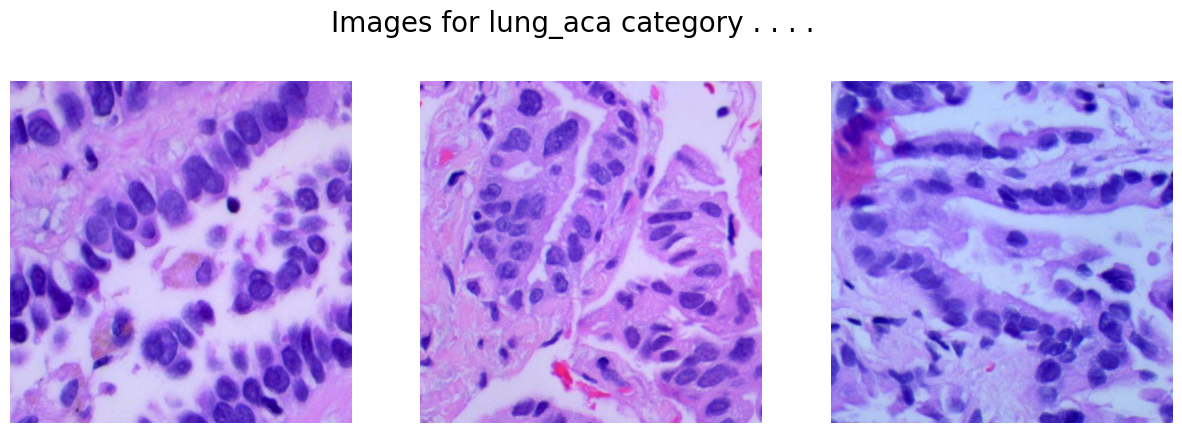

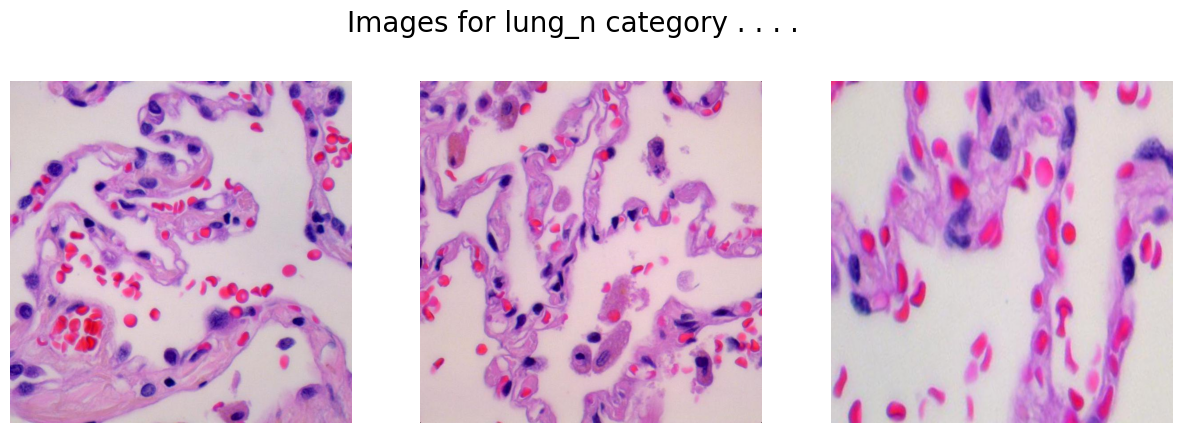

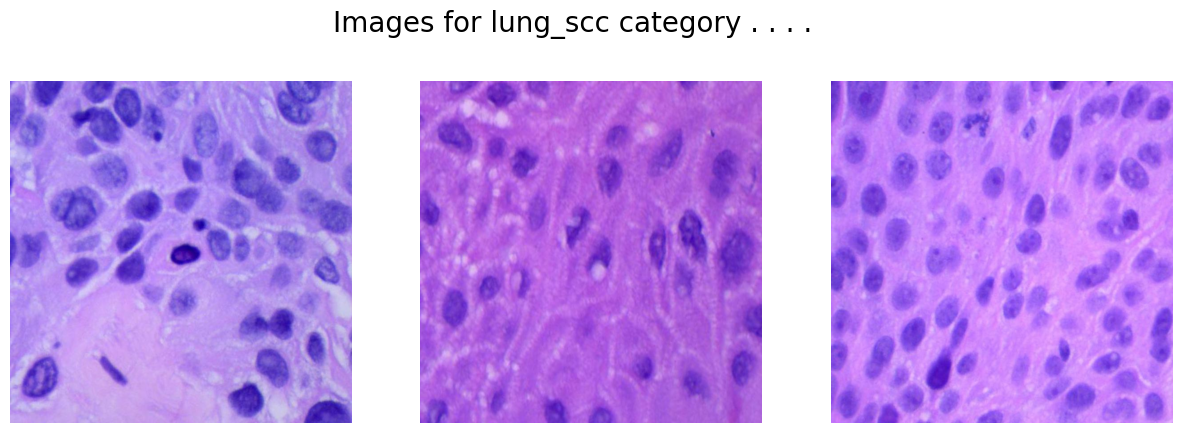

In [6]:
path = 'lung_colon_image_set/lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [7]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [8]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [12]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [15]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [18]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1141s 6s/step - accuracy: 0.9386 - loss: 0.1644 - val_accuracy: 0.5147 - val_loss: 2.3083 - learning_rate: 5.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.9536 - loss: 0.1212 - val_accuracy: 0.8083 - val_loss: 0.5941 - learning_rate: 5.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.9571 - loss: 0.1118 - val_accuracy: 0.8850 - val_loss: 0.4262 - learning_rate: 5.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.9748 - loss: 0.0741 - val_accuracy: 0.8180 - val_loss: 0.6060 - learning_rate: 5.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9763 - loss: 0.0669
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
188/188 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.9763 - loss: 0.0669 - val_accuracy: 0.3987 - val_loss: 8.4488 - learning_rate: 5.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0

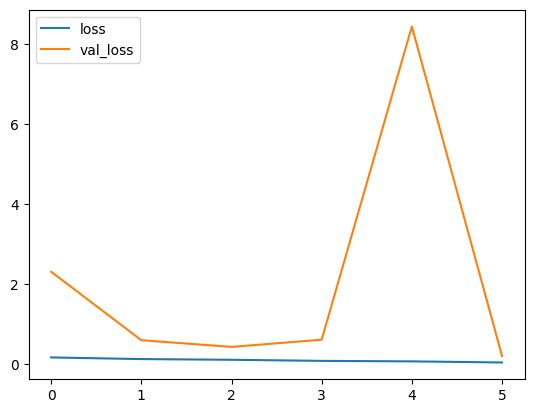

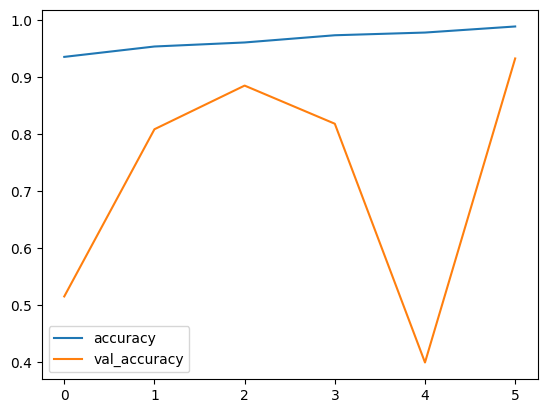

In [19]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [20]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step


In [21]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[864,   0, 123],
       [ 30, 947,   0],
       [ 49,   0, 987]], dtype=int64)

In [22]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.92      0.88      0.90       987
      lung_n       1.00      0.97      0.98       977
    lung_scc       0.89      0.95      0.92      1036

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



In [24]:
model.save('98_93_model.h5')
print('ok')

ok


# prediction functions

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import datetime
import os
import cv2

In [3]:
# Model loading function with error handling
def load_model(model_path):
    try:
        return tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"Error loading model '{model_path}': {e}")
        return None
    
def preprocessing(img, img_shape):
    # Keep as RGB
    img = np.array(img)
    img = cv2.resize(img, img_shape)  # Resize to model's expected input size
#    img = img / norm_fac  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_lung_cancer(image):
    model = load_model('lung_model.h5')
    if model is None:
        return "Error: Model could not be loaded"
    
    processed_img = preprocessing(image, (256,256))
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_names = ['Lung adenocarcinoma', 'Lung benign tissue', 'Lung squamous cell carcinoma']
    prediction = class_names[predicted_class]
        
    result = {
        "Prediction": prediction,
        "Analysis Date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "Note": "This is an automated analysis and should be verified by a healthcare professional."
    }
    
    return result

In [8]:
img1 = cv2.imread("imags\lung_aca.jpeg")
img2 = cv2.imread("imags\lung_n.jpeg")
img3 = cv2.imread("imags\lung_scc.jpeg")

predict_lung_cancer(img1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


{'Prediction': 'Lung adenocarcinoma',
 'Analysis Date': '2024-10-24 14:33:57',
 'Note': 'This is an automated analysis and should be verified by a healthcare professional.'}